In [ ]:
%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import os
import joblib
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.optimize import nnls
from transformers import pipeline
from tqdm import tqdm

import helpers.helpers as hp
import helpers.data_prep as dp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set pandas options
pd.set_option('display.max_colwidth', None)   # no truncation of string columns
pd.set_option('display.max_columns', None)    # show all columns (optional)
pd.set_option('display.width', None)          # auto-detect line width (optional)

## Load, translate and score datasets

In [3]:
# load datasets
flores101, hebNLI = dp.load_datasets()
sentences = flores101["eng"].to_list()
references = flores101["heb"].to_list()

In [6]:
# load / translate and score flores with helsinki-nlp
hs_flores_path = "datasets/pkl_data/hs_flores101.pkl"
if os.path.exists(hs_flores_path):
    hs_flores = pd.read_pickle(hs_flores_path)
else:
    translations = hp.batch_translate_hs(sentences)
    scores = hp.batch_scores(sentences, translations, references)
    hs_flores = dp.create_translated_df(sentences, translations, references, scores, method="hs", dataset="flores101")

Scoring BLEU: 997it [00:00, 12699.67it/s]
Scoring CHRF: 997it [00:00, 5604.85it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores


In [8]:
# load / translate and score flores with google translate
gt_flores_path = "datasets/pkl_data/gt_flores101.pkl"
if os.path.exists(gt_flores_path):
    gt_flores = pd.read_pickle(gt_flores_path)
else:
    translations = hp.translate_gt(sentences)
    scores = hp.batch_scores(sentences, translations, references)
    gt_flores = dp.create_translated_df(sentences, translations, references, scores, method="gt", dataset="flores101")

Translating: 100%|██████████| 997/997 [05:41<00:00,  2.92it/s]
Scoring BLEU: 997it [00:00, 10357.36it/s]
Scoring CHRF: 997it [00:00, 5550.55it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores


In [9]:
# load / translate and score flores with helsinki-nlp word by word
wbw_flores_path = "datasets/pkl_data/wbw_flores101.pkl"
if os.path.exists(wbw_flores_path):
    wbw_flores = pd.read_pickle(wbw_flores_path)
else:
    translations = hp.batch_translate_wbw_hs(sentences)
    scores = hp.batch_scores(sentences, translations, references)
    wbw_flores = dp.create_translated_df(sentences, translations, references, scores, method="wbw", dataset="flores101")

Translating: 100%|██████████| 111/111 [00:55<00:00,  2.02it/s]
Scoring BLEU: 997it [00:00, 10999.20it/s]
Scoring CHRF: 997it [00:00, 5641.41it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores


In [10]:
# load / translate and score flores with helsinki-nlp english-chinese-hebrew
pv_flores_path = "datasets/pkl_data/pv_flores101.pkl"
if os.path.exists(pv_flores_path):
    pv_flores = pd.read_pickle(pv_flores_path)
else:
    translations = hp.batch_translate_hs_pv(sentences)
    scores = hp.batch_scores(sentences, translations, references)
    pv_flores = dp.create_translated_df(sentences, translations, references, scores, method="pv", dataset="flores101")

Translating Chinese -> Hebrew: 100%|██████████| 16/16 [00:40<00:00,  2.54s/it]
Scoring BLEU: 997it [00:00, 9721.50it/s]
Scoring CHRF: 997it [00:00, 6671.35it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores


In [95]:
# update score

translations = hs_flores["heb_translation"].to_list()
scores = hp.batch_scores(sentences, translations, references)
hs_flores = dp.create_translated_df(sentences, translations, references, scores, method="hs", dataset="flores101")

print()
translations = gt_flores["heb_translation"].to_list()
scores = hp.batch_scores(sentences, translations, references)
gt_flores = dp.create_translated_df(sentences, translations, references, scores, method="gt", dataset="flores101")

print()
translations = pv_flores["heb_translation"].to_list()
scores = hp.batch_scores(sentences, translations, references)
pv_flores = dp.create_translated_df(sentences, translations, references, scores, method="pv", dataset="flores101")

print()
translations = wbw_flores["heb_translation"].to_list()
scores = hp.batch_scores(sentences, translations, references)
wbw_flores = dp.create_translated_df(sentences, translations, references, scores, method="wbw", dataset="flores101")

Scoring BLEU: 997it [00:00, 12995.31it/s]
Scoring CHRF: 997it [00:00, 5496.60it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores



Scoring BLEU: 997it [00:00, 12799.25it/s]
Scoring CHRF: 997it [00:00, 5648.61it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores



Scoring BLEU: 997it [00:00, 14418.73it/s]
Scoring CHRF: 997it [00:00, 6734.48it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores



Scoring BLEU: 997it [00:00, 11803.84it/s]
Scoring CHRF: 997it [00:00, 5735.59it/s]


Scoring BERT scores
Scoring Bi-Di-Entailment scores
Computing Cosine Similarity
Computing Penalties
Computing Hebrew Perplexity
Computing scores


## Training

In [102]:
# Data preperation for training

bde= []
cos_sim = []
nce = []
penalties = []
heb_fluency = []
label = []
dfs = [hs_flores, gt_flores, wbw_flores, pv_flores]
for df in dfs:
    bde.extend(df["bde_score"].to_list())
    cos_sim.extend(df["cos_sim"].to_list())
    penalties.extend(df["penalties"].to_list())
    heb_fluency.extend(df["heb_fluency"].to_list())
    label.extend(df["chrf_score"].to_list())

nll_df = pd.DataFrame({
    "bde": bde,
    "cos_sim": cos_sim,
    "penalties": penalties,
    "heb_fluency": heb_fluency,
    "label": label,
})

In [ ]:
#features
features_names = ["bde", "cos_sim", "penalties", "heb_fluency"]
bde = nll_df["bde"].to_numpy()
cos_sim = nll_df["cos_sim"].to_numpy()
penalties = nll_df["penalties"].to_numpy()
heb_fluency = nll_df["heb_fluency"].to_numpy()
y = nll_df["label"].to_numpy()

X = np.vstack([bde, cos_sim, penalties, heb_fluency]).T
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
w, _ = nnls(X_train_scaled, y_train)
b = float(y_train.mean() - (X_train_scaled @ w).mean())

s_tr = X_train_scaled @ w + b
iso = IsotonicRegression(increasing = True, y_min = y_train.min(), y_max=y_train.max(), out_of_bounds="clip").fit(s_tr, y_train)
s_ts = X_test_scaled @ w + b
y_hat = iso.predict(s_ts)

r2_raw = r2_score(y_test, s_ts)
sp_raw = spearmanr(y_test, s_ts).correlation
r2_iso = r2_score(y_test, y_hat)
sp_iso = spearmanr(y_test, y_hat).correlation

print(f"Validation (raw)     -> R2: {r2_raw:.3f}  Spearman: {sp_raw:.3f}")
print(f"Validation (isotonic)-> R2: {r2_iso:.3f}  Spearman: {sp_iso:.3f}")

# save the model
artifacts = {
    "feature_names": features_names,
    "w": w, "b": b,
    "scaler": scaler,
    "iso": iso,
}
joblib.dump(artifacts, "models/mt_score.joblib")


Validation (raw)     -> R2: 0.469  Spearman: 0.724
Validation (isotonic)-> R2: 0.493  Spearman: 0.724


['models/mt_score.joblib']

## Exploring results

In [142]:
print("Google Translate Scores")
print(gt_flores[['bleu_score', 'chrf_score','bert_score', 'bde_score', 'cos_sim', 'penalties', 'heb_fluency', 'mt_score']].agg(["mean", "min", "max", "std"]),"\n")

print("Helsinki NLP English - Hebrew Scores")
print(hs_flores[['bleu_score', 'chrf_score','bert_score', 'bde_score', 'cos_sim', 'penalties', 'heb_fluency', 'mt_score']].agg(["mean", "min", "max", "std"]),"\n")

print("Helsinki NLP English - Chinese - Hebrew Scores")
print(pv_flores[['bleu_score', 'chrf_score','bert_score', 'bde_score', 'cos_sim', 'penalties', 'heb_fluency', 'mt_score']].agg(["mean", "min", "max", "std"]),"\n")

print("Helsinki NLP word-by-words Scores")
print(wbw_flores[['bleu_score', 'chrf_score','bert_score', 'bde_score', 'cos_sim', 'penalties', 'heb_fluency', 'mt_score']].agg(["mean", "min", "max", "std"]),"\n")

Google Translate Scores
      bleu_score  chrf_score  bert_score  bde_score   cos_sim  penalties  \
mean   28.247307   59.130644    0.883179   0.395836  0.947274   0.777061   
min     2.375550   13.177077    0.743776   0.000000  0.816866   0.150000   
max   100.000000  100.000000    1.000000   1.000000  0.989543   1.000000   
std    17.420760   13.913767    0.047087   0.284671  0.017586   0.110332   

      heb_fluency   mt_score  
mean     0.763254  55.400295  
min      0.000000  22.560246  
max      1.000000  89.844739  
std      0.110359   8.348793   

Helsinki NLP English - Hebrew Scores
      bleu_score  chrf_score  bert_score  bde_score   cos_sim  penalties  \
mean   25.917088   56.681435    0.875249   0.384560  0.942004   0.767416   
min     1.660250   20.900055    0.726603   0.000000  0.801286   0.272727   
max   100.000000  100.000000    1.000000   1.000000  0.989543   1.000000   
std    16.341242   13.699627    0.048432   0.289977  0.021690   0.120987   

      heb_fluency   

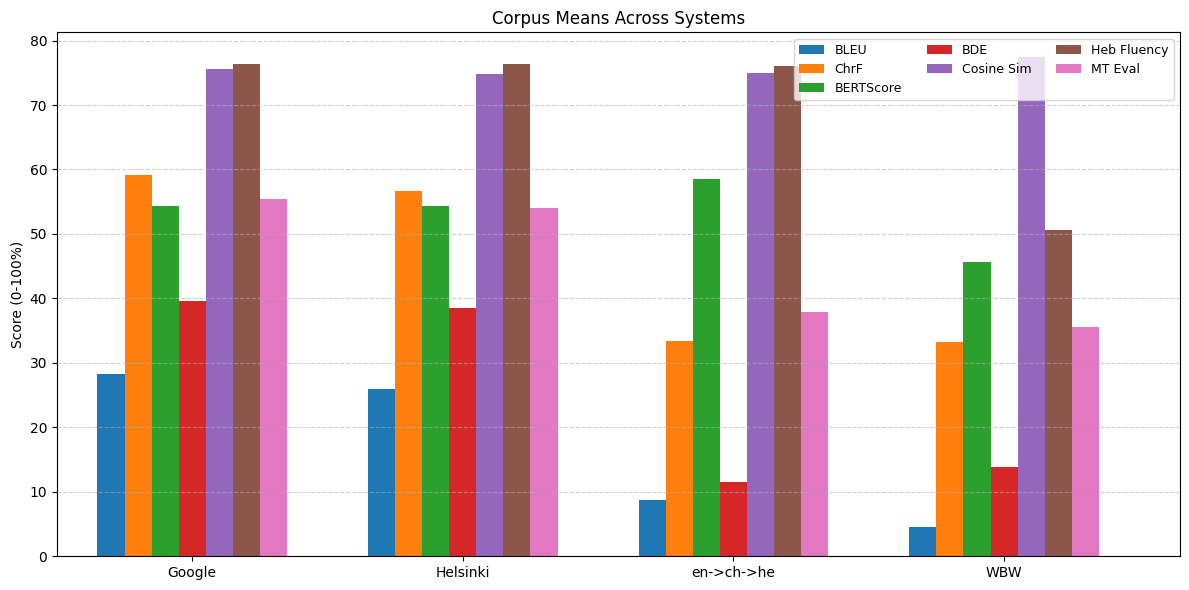

In [96]:
features = ['bleu_score', 'chrf_score', 'bert_score', 'bde_score',
            'cos_sim', 'heb_fluency', 'mt_score']

systems = {
    "Google":   gt_flores,
    "Helsinki": hs_flores,
    "en->ch->he": pv_flores,
    "WBW":      wbw_flores,
}

label_map = {
    "bleu_score": "BLEU",
    "chrf_score": "ChrF",
    "bert_score": "BERTScore",
    "bde_score": "BDE",
    "cos_sim": "Cosine Sim",
    "nce_score": "NCE",
    "heb_fluency": "Heb Fluency",
    "mt_score": "MT Eval"
}

def scale(series, name):
    if name not in ["bleu_score", "chrf_score", "mt_score"]:
        return 100 * (series - series.min()) / (series.max() - series.min())    
    return series 
    
means = {}
for sys_name, df in systems.items():
    vals = {}
    for f in features:
        vals[f] = scale(df[f], f).mean()
    means[sys_name] = vals
means = pd.DataFrame(means).T

x = np.arange(len(means.index))
w = 0.1 
spacing = 0.15 

plt.figure(figsize=(12, 6))
for j, f in enumerate(features):
    plt.bar(x + (j - (len(features)-1)/2) * w, means[f], width=w, label=label_map.get(f, f))

plt.xticks(x, means.index)
plt.ylabel("Score (0-100%)")
plt.title("Corpus Means Across Systems")
plt.legend(ncol=3, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.gca().set_xlim(x[0] - 0.5, x[-1] + 0.5 + spacing)

plt.tight_layout()
plt.show()

In [81]:
means

,bleu_score,chrf_score,bert_score,bde_score,cos_sim,nce_score,heb_fluency,mt_score
Google,28.247307,59.130644,54.406896,39.583573,75.521194,95.649029,76.325441,55.400295
Helsinki,25.917088,56.681435,54.370013,38.456028,74.747865,93.031378,76.358691,54.035000
en->ch->he,8.688187,33.440777,58.486562,11.576107,74.895776,92.529647,76.031462,37.925762
WBW,4.508874,33.285908,45.659351,13.799949,77.403250,95.651463,50.569435,35.567668


In [114]:
bde = hs_flores["bde_score"].to_list()
bde.extend(gt_flores["bde_score"].to_list())
bde.extend(pv_flores["bde_score"].to_list())
bde.extend(wbw_flores["bde_score"].to_list())

mt_score = hs_flores["mt_score"].to_list()
mt_score.extend(gt_flores["mt_score"].to_list())
mt_score.extend(pv_flores["mt_score"].to_list())
mt_score.extend(wbw_flores["mt_score"].to_list())

chrf = hs_flores["chrf_score"].to_list()
chrf.extend(gt_flores["chrf_score"].to_list())
chrf.extend(pv_flores["chrf_score"].to_list())
chrf.extend(wbw_flores["chrf_score"].to_list())

all_scores = pd.DataFrame({
    "bde": bde,
    "mt_score": mt_score,
    "chrf": chrf,
})


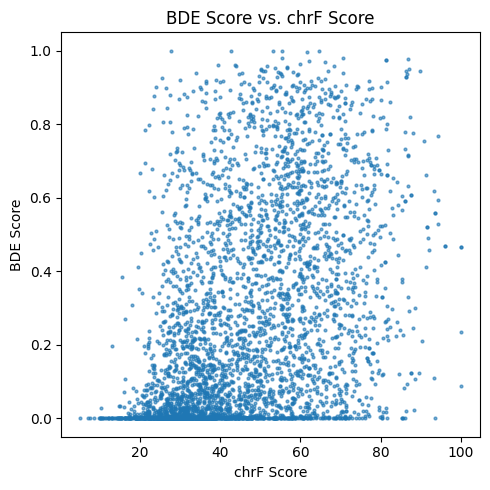

In [127]:
plt.figure(figsize=(5,5))
plt.scatter(x=chrf, y=bde, s=4, marker='o', alpha=0.6)
plt.title("BDE Score vs. chrF Score")
plt.xlabel("chrF Score")
plt.ylabel("BDE Score")

plt.tight_layout()
plt.show()

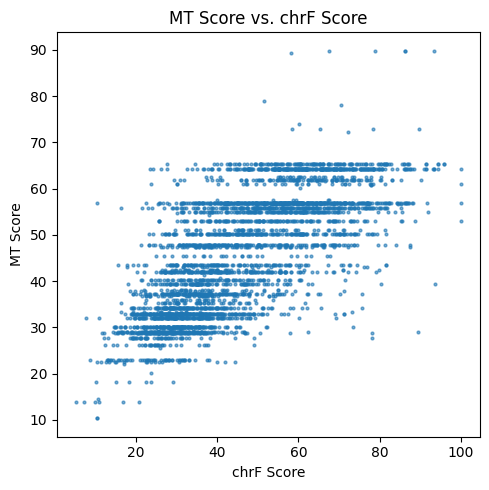

In [133]:
plt.figure(figsize=(5,5))
plt.scatter(x=chrf, y=mt_score, s=4, marker='o', alpha=0.6)
plt.title("MT Score vs. chrF Score")
plt.xlabel("chrF Score")
plt.ylabel("MT Score")

plt.tight_layout()
plt.show()

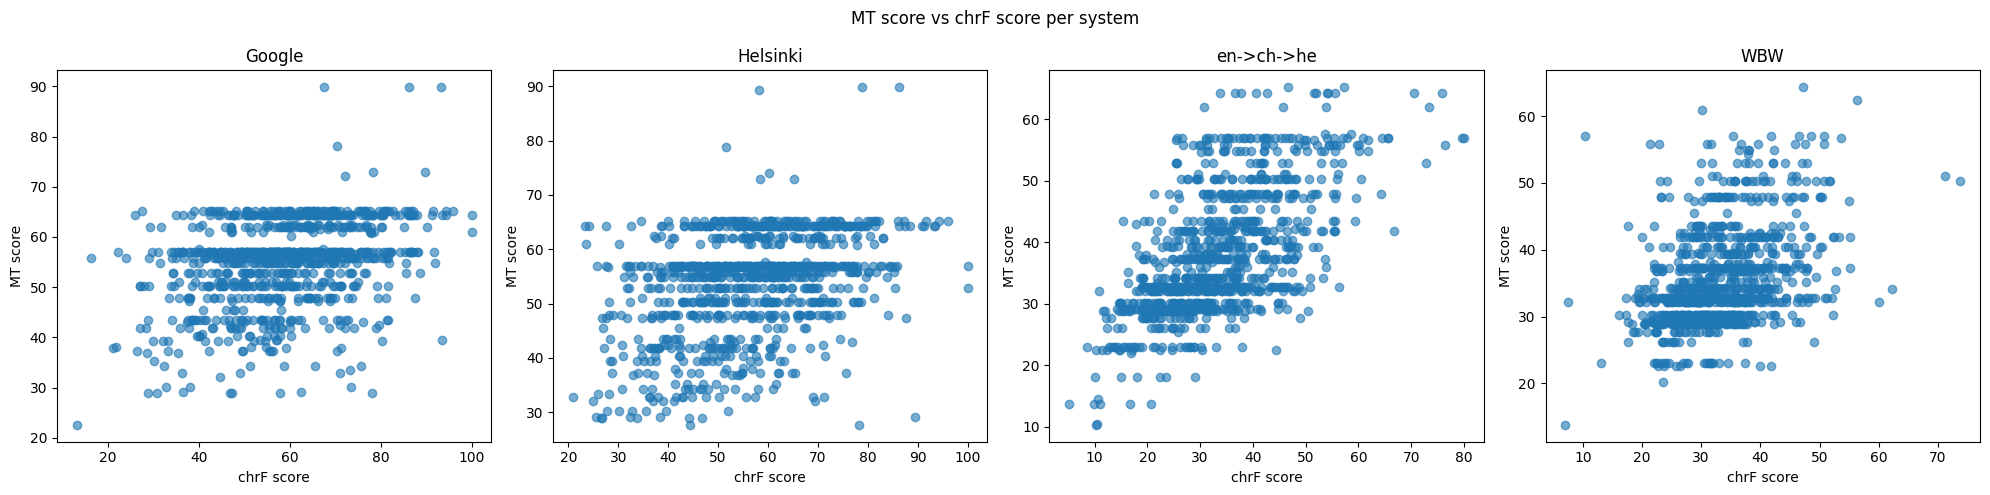

In [111]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, (name, df) in zip(axes.flat, systems.items()):
    ax.scatter(df["chrf_score"], df["mt_score"], alpha=0.6)
    ax.set_title(name)
    ax.set_xlabel("chrF score")
    ax.set_ylabel("MT score")

plt.suptitle("MT score vs chrF score per system")
plt.tight_layout()
plt.show()

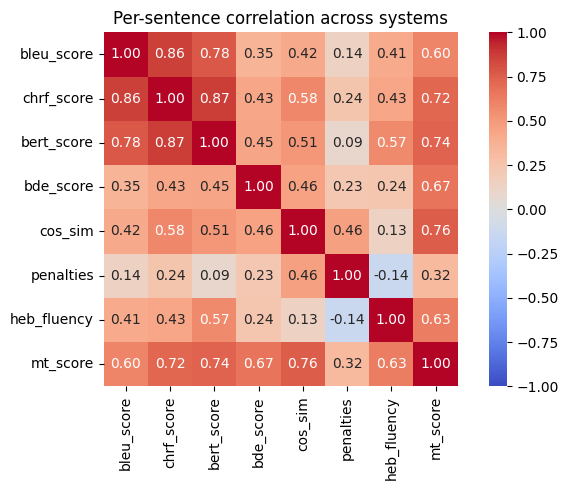

In [146]:
features = ['bleu_score', 'chrf_score', 'bert_score', 'bde_score',
            'cos_sim', 'penalties', 'heb_fluency', 'mt_score']

rows = []
for name, df in systems.items():
    X = df[features].copy()
    X['system'] = name
    rows.append(X)

all_df = pd.concat(rows, ignore_index=True)

num = all_df.drop(columns='system')
corr = num.corr(method='pearson')

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Per-sentence correlation across systems")
plt.tight_layout()
plt.show()

## Testing Entailment

In [153]:
hebNLI.head()

,original_annotator_labels,genre,original_label,pairID,promptID,sentence1,translation1,sentence2,translation2
0,['neutral'],slate,neutral,24413n,24413,"So anyway, maybe he'll put this Willie Horton guy on the ticket after all is said and done.","אז בכל מקרה, אולי הוא ישים את ווילי הורטון הזה על הכרטיס אחרי הכול.",Not that many people know who Willie Horton is.,לא הרבה אנשים יודעים מי זה ווילי הורטון.
1,['contradiction'],government,contradiction,16902c,16902,Has adequate attention been given to the outliers?,האם ניתנה תשומת לב מספקת לערכים חריגים?,"Outliers do not need any attention, do they?","לסטיות לא צריך לתת שום תשומת לב, נכון?"
2,['entailment'],government,entailment,63601e,63601,"As agreed with the participants, the purpose of the discussion was not to reach a consensus, but rather to engage in an open, no attribution-based dialogue.","כפי שסוכם עם המשתתפים, מטרת הדיון לא הייתה להגיע לקונצנזוס, אלא לעסוק בדיאלוג פתוח ללא ייחוס.",An agreement was made with participants to ensure that the discussion would involve open dialogue.,הוסכם עם המשתתפים לוודא שהדיון יכלול שיח פתוח.
3,['neutral'],slate,neutral,142332n,142332,"In the bottom-right corner, click Bomis , which will take you ...","בפינה הימנית התחתונה, לחץ על Bomis , שייקח אותך ...","You'll be happy to click Bomis, in the right-hand corner.","תשמח ללחוץ על בומיס, בפינה הימנית."
4,['neutral'],fiction,neutral,34925n,34925,"Worth a million dollars!""","שווה מיליון דולר!""",It was purchased for a lower price.,זה נרכש במחיר נמוך יותר.


In [154]:
en_entailment = pipeline("text-classification", model="roberta-large-mnli") # en-en entailment model 
cl_entailment = pipeline("text-classification", model="joeddav/xlm-roberta-large-xnli") # cross-lingual entailment model

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the ch

In [155]:
# Testing en and cl entailment on flores101

m = flores101.shape[0]
en_correct = 0
cl_correct = 0

for i in tqdm(range(m), desc="labeling"): #
    p = flores101.loc[i, 'eng']
    h = flores101.loc[i, 'heb']
    en_result = en_entailment({"text": p, "text_pair": h}, truncation=True)
    cl_result = cl_entailment({"text": p, "text_pair": h}, truncation=True)
    if (en_result['label'].lower() == "entailment"):
        en_correct += 1
    if (cl_result['label'].lower() == "entailment"):
        cl_correct += 1

print(f"English English entailment accuracy: {en_correct/m}")
print(f"Cross Lingual entailment accuracy: {cl_correct/m}")

labeling: 100%|██████████| 997/997 [01:28<00:00, 11.32it/s]

English English entailment accuracy: 0.5957873620862588
Cross Lingual entailment accuracy: 0.9929789368104313


In [156]:
# Testing en and cl entailment on hebrew NLI

m = hebNLI.shape[0]
mm = 1000
en_correct = 0
cl_correct = 0

for i in tqdm(range(mm), desc="labeling"): #
    p = hebNLI.loc[i, 'sentence1']
    h = hebNLI.loc[i, 'translation2']
    en_result = en_entailment(f"{p} </s> {h}")[0]
    cl_result = cl_entailment(f"{p} </s> {h}")[0]
    if (en_result['label'].lower() == hebNLI.loc[i, 'original_label']):
        en_correct += 1
    if (cl_result['label'].lower() == hebNLI.loc[i, 'original_label']):
        cl_correct += 1

print(f"English English entailment accuracy: {en_correct/mm}")
print(f"Cross Lingual entailment accuracy: {cl_correct/mm}")

labeling: 100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]

English English entailment accuracy: 0.352
Cross Lingual entailment accuracy: 0.835


In [134]:
# Testing en and cl entailment on hebrew NLI dataset translations

m = hebNLI.shape[0]
mm = int(0.01*m)

en_scores = []
cl_scores = []
en_rand_scores = []
cl_rand_scores = []

for i in tqdm(range(mm), desc="labeling"): #
    p = hebNLI.loc[i, 'sentence1']
    h = hebNLI.loc[i, 'translation1']
    r = random.randint(0, m)
    h_rand = hebNLI.loc[r, 'translation1']

    en_result = en_entailment({"text": p, "text_pair": h}, truncation=True, top_k=None)
    en_score = next(d["score"] for d in en_result if d["label"].lower().startswith("entailment"))
    en_scores.append(en_score)

    cl_result = cl_entailment({"text": p, "text_pair": h}, truncation=True, top_k=None)
    cl_score = next(d["score"] for d in cl_result if d["label"].lower().startswith("entailment"))
    cl_scores.append(cl_score)

    en_result_rand = en_entailment({"text": p, "text_pair": h_rand}, truncation=True, top_k=None)
    en_rand_score = next(d["score"] for d in en_result_rand if d["label"].lower().startswith("entailment"))
    en_rand_scores.append(en_rand_score)

    cl_result_rand = cl_entailment({"text": p, "text_pair": h_rand}, truncation=True, top_k=None)
    cl_rand_score = next(d["score"] for d in cl_result_rand if d["label"].lower().startswith("entailment"))
    cl_rand_scores.append(cl_rand_score)

en_scores = np.array(en_scores)
cl_scores = np.array(cl_scores)
en_rand_scores = np.array(en_rand_scores)
cl_rand_scores = np.array(cl_rand_scores)

print("English Entailment Model")
print(f"Average Entailment Score on true translations {np.mean(en_scores)}")
print(f"Average Entailment Score on random sentences  {np.mean(en_rand_scores)}")
print()
print("Cross Lingual Entailment Model")
print(f"Average Entailment Score on true translations {np.mean(cl_scores)}")
print(f"Average Entailment Score on random sentences  {np.mean(cl_rand_scores)}")

labeling: 100%|██████████| 3001/3001 [06:09<00:00,  8.12it/s]


English Entailment Model
Average Entailment Score on true translations 0.38197192943151276
Average Entailment Score on random sentences  0.3205310029183446

Cross Lingual Entailment Model
Average Entailment Score on true translations 0.9873035246988054
Average Entailment Score on random sentences  0.053545249775254565


In [148]:
hs_flores[hs_flores["bleu_score"] == hs_flores["bleu_score"].min()]

,eng,heb_reference,heb_translation,bleu_score,chrf_score,bert_score,bde_score,cos_sim,penalties,heb_fluency,mt_score
215,"The International Olympic Committee voted to include the sports at its executive board meeting in Berlin today. Rugby, specifically rugby union, and golf were selected over five other sports to be considered to participate in the Olympics.","הוועד האולימפי הבינלאומי הצביע בישיבת מועצת המנהלים שלו שהתקיימה היום בברלין על הכללת ענפי ספורט. גולף ורוגבי, ובפרט רוגבי יוניון נבחרו על פני חמישה ענפי ספורט אחרים שהיו מועמדים להשתתפות באולימפיאדה.","הועדה האולימפית הבינלאומית הצביעה לכלול את הספורט בישיבת ההנהלה בברלין היום רוגבי, במיוחד איגוד הרוגבי, וגולף נבחרו ליותר מחמישה ספורטאים אחרים",1.66025,34.970319,0.750464,0.085924,0.922143,0.567568,0.567687,34.201606


In [149]:
wbw_flores[wbw_flores["bleu_score"] == wbw_flores["bleu_score"].min()]

,eng,heb_reference,heb_translation,bleu_score,chrf_score,bert_score,bde_score,cos_sim,penalties,heb_fluency,mt_score
766,"The city of Beijing in China will be the host city of the Olympic Winter Games in 2022, which will make it the first city to have hosted both the summer and winter Olympics.","העיר בייג'ין בסין תארח את אולימפיאדת החורף ב-2022, מה שאומר שהיא תהיה העיר הראשונה שאירחה גם את אולימפיאדת הקיץ וגם את אולימפיאדת החורף.","The עיר של בייג' ינגworld. kgm ב סין וויל. להיות The מארח עיר של The אולימפי חורף משחקים ב 2022, איזה וויל. הפוך זה. The קודם עיר אל יש מארח שניהם The קיץ ו חורף אולימפיאדה.",1.03854,29.056243,0.652333,0.000199,0.938904,0.760802,0.484134,34.201606


In [152]:
hs_flores[hs_flores["mt_score"] == hs_flores["mt_score"].max()]

,eng,heb_reference,heb_translation,bleu_score,chrf_score,bert_score,bde_score,cos_sim,penalties,heb_fluency,mt_score
245,I am happy that there are people willing to support me.,אני שמח שיש אנשים המוכנים לתמוך בי.,אני שמח שיש אנשים שמוכנים לתמוך בי.,50.000000,86.318857,0.979019,0.928134,0.964327,0.636364,0.986003,89.844739
697,"Jerusalem has many historic, archeological and cultural sites, along with vibrant and crowded shopping centers, cafés, and restaurants.","בירושלים יש הרבה אתרים היסטוריים, ארכאולוגיים ותרבותיים, ביחד עם מרכזי קניות תוססים וצפופים, בתי קפה ומסעדות.","בירושלים יש אתרים היסטוריים, ארכיאולוגיים ותרבותיים רבים, יחד עם מרכזי קניות מלאי חיים וצפופים, בתי קפה ומסעדות.",37.629571,78.901437,0.958180,0.707719,0.967725,0.944444,0.992970,89.844739


In [150]:
wbw_flores[wbw_flores["mt_score"] == wbw_flores["mt_score"].min()]

,eng,heb_reference,heb_translation,bleu_score,chrf_score,bert_score,bde_score,cos_sim,penalties,heb_fluency,mt_score
334,Then Whirling Dervishes took to the stage.,הדרווישים המסתובבים עלו על הבמה.,אז צווחות asia. kgm תפוס. אל The שלב.,3.747777,7.063672,0.650697,3.563800e-08,0.68891,0.6125,0.499623,13.806304


## Tests & Experiments

In [11]:
# how cross-lingual entailment model treat different level of translations
pairs = [
    "החתול ישן על הספה בכל אחר הצהריים",  # Perfect
    "החתול ישן הספה בכל אחר הצהריים",  # Grammar issue
    "הכלב ישן על הספה בכל אחר הצהריים",  # Wrong subject
    "החתול ישן על המיטה בכל אחר הצהריים",  # Wrong location
    "החתול ישן על הספה",  # Missing time
    "החתול על הספה בכל אחר הצהריים",  # Missing verb
    "החתול רץ על הספה בכל אחר הצהריים",  # Opposite meaning    
    "החתול לא ישן על הספה בכל אחר הצהריים",  # Negation
    "החתול ישן על הספה בכל אחר הצהריים בזמן שהמכונית בחוץ",  # Extra info
    "על הספה ישן בכל אחר הצהריים החתול",  # Word order scrambled
    "הדלי כן ירוק צבא הוא מכונית מורה שלך ברוסיה",
]

# ---- usage with your Hebrew hypotheses list `translations`
nll = hebrew_pseudo_perplexity(pairs, max_len=256)
flu_pen = fluency_penalty_from_nll(nll)

In [6]:
# testing labse and e5 on refs

ref = "החתול ישן על הספה בכל אחר הצהריים"
for i, (p, h) in enumerate(pairs, start=1):
    result = util.cos_sim(
        e5.encode(f"query: {ref}", normalize_embeddings=True),
        e5.encode(f"query: {h}", normalize_embeddings=True)
    ).item()
    lab = util.cos_sim(
        labse.encode(ref, normalize_embeddings=True),
        labse.encode(h, normalize_embeddings=True)
    ).item()
    
    print(f"Labse: {lab}\ne5: {result}\n{h}")
    print()

Labse: 1.0
e5: 1.0000001192092896
החתול ישן על הספה בכל אחר הצהריים

Labse: 0.9806516170501709
e5: 0.9886281490325928
החתול ישן הספה בכל אחר הצהריים

Labse: 0.9809930324554443
e5: 0.9718356132507324
הכלב ישן על הספה בכל אחר הצהריים

Labse: 0.980108380317688
e5: 0.9885897040367126
החתול ישן על המיטה בכל אחר הצהריים

Labse: 0.8694499731063843
e5: 0.959738552570343
החתול ישן על הספה

Labse: 0.9452909231185913
e5: 0.9798159599304199
החתול על הספה בכל אחר הצהריים

Labse: 0.9393529295921326
e5: 0.9749166369438171
החתול רץ על הספה בכל אחר הצהריים

Labse: 0.9330158829689026
e5: 0.972147524356842
החתול לא ישן על הספה בכל אחר הצהריים

Labse: 0.8935500383377075
e5: 0.9744758605957031
החתול ישן על הספה בכל אחר הצהריים בזמן שהמכונית בחוץ

Labse: 0.9663166403770447
e5: 0.9860313534736633
על הספה ישן בכל אחר הצהריים החתול



In [9]:
xnli = pipeline("text-classification", model="joeddav/xlm-roberta-large-xnli")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [10]:
# cross lingual entailment scores for pairs

ref = "החתול ישן על הספה בכל אחר הצהריים"
for i, (p, h) in enumerate(pairs, start=1):
    result = xnli({"text": p, "text_pair": h}, top_k=None)
    entail = next(d["score"] for d in result if d["label"].lower().startswith("entailment"))
    print(h, entail)
    print()

החתול ישן על הספה בכל אחר הצהריים 0.9035382270812988

החתול ישן הספה בכל אחר הצהריים 0.9962109327316284

הכלב ישן על הספה בכל אחר הצהריים 0.7347667217254639

החתול ישן על המיטה בכל אחר הצהריים 0.07882726192474365

החתול ישן על הספה 0.5717940926551819

החתול על הספה בכל אחר הצהריים 0.9738508462905884

החתול רץ על הספה בכל אחר הצהריים 0.30617988109588623

החתול לא ישן על הספה בכל אחר הצהריים 0.9990262985229492

החתול ישן על הספה בכל אחר הצהריים בזמן שהמכונית בחוץ 0.0010024907533079386

על הספה ישן בכל אחר הצהריים החתול 0.9971166849136353



In [11]:
# cross lingual entailment scores for ref

ref = "החתול ישן על הספה בכל אחר הצהריים"
for i, (p, h) in enumerate(pairs, start=1):
    result = xnli({"text": ref, "text_pair": h}, top_k=None)
    entail = next(d["score"] for d in result if d["label"].lower().startswith("entailment"))
    print(h, entail)
    print()

החתול ישן על הספה בכל אחר הצהריים 0.9996422529220581

החתול ישן הספה בכל אחר הצהריים 0.999289870262146

הכלב ישן על הספה בכל אחר הצהריים 0.9996356964111328

החתול ישן על המיטה בכל אחר הצהריים 0.13737860321998596

החתול ישן על הספה 0.99959796667099

החתול על הספה בכל אחר הצהריים 0.9995437264442444

החתול רץ על הספה בכל אחר הצהריים 0.01436981838196516

החתול לא ישן על הספה בכל אחר הצהריים 0.06796538084745407

החתול ישן על הספה בכל אחר הצהריים בזמן שהמכונית בחוץ 0.0003005341568496078

על הספה ישן בכל אחר הצהריים החתול 0.9996834993362427

